In [20]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading CTR Data for AB Test

In [ ]:
# Load the dat form the csv file
df_ab_test = pd.read_csv('ab_test_click_data.csv')

# Display the first rows of the DataFrame to cofirm it's load correctyly
print(df_ab_test.head())
print(df_ab_test.describe())
# df.groupby("col_name")["specific_col"].statistic_func()
print(df_ab_test.groupby("group")[["user_id", "click"]].sum())
print(df_ab_test.groupby(['group', 'click']).size().reset_index(name='count'))

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   1989
exp     50005000   6116
group  click
con    0        8011
       1        1989
exp    0        3884
       1        6116
dtype: int64


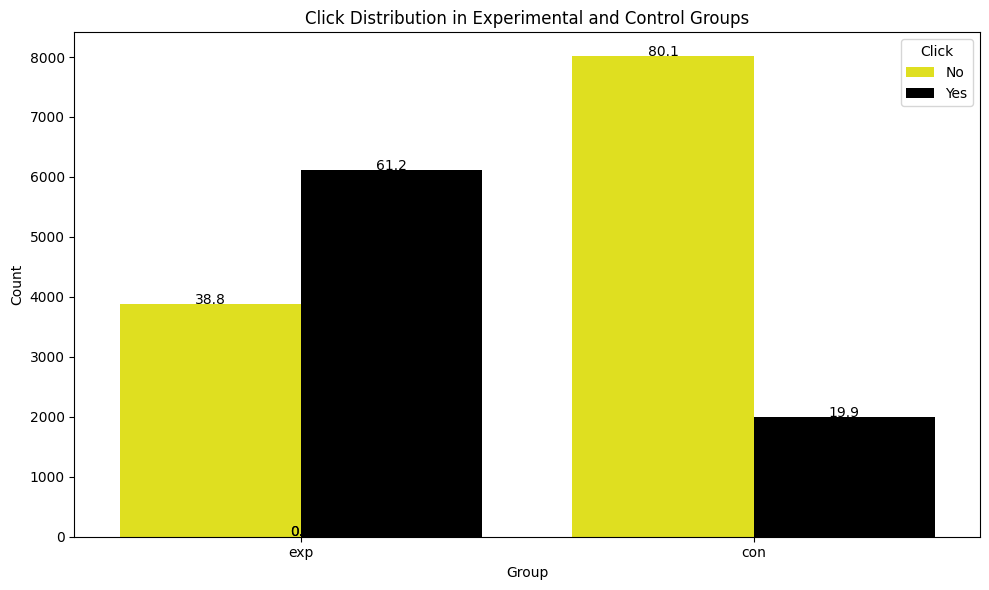

In [29]:
# Custom palette for yellow and black
palette = {0: "yellow", 1: "black"} # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6)) # width=10, height=6
# Count rows in DataFrame
# Group (con/exp) on x axis, count hue={0, 1} for (con/exp), use palette color
ax = sns.countplot(x="group", hue="click", data=df_ab_test, palette=palette)
plt.title("Click Distribution in Experimental and Control Groups")
plt.xlabel("Group")
plt.ylabel("Count")
# llabels=["No", "Yes"] => [0, 1] in hue values
plt.legend(title="Click", labels=["No", "Yes"])

# calculate the percentages and annotate the bars (count NAN values # count())
group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # Find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}', ha="center", color="black", fontsize="10")

plt.tight_layout()
plt.show()